## Stacking Model on Titanic Dataset
#
By __Gaël Linkeu__
#### We try to predict with a stacking model if the passenger of the Titanic boat will survive or not

This stacking model will have 
* KNN
* Neural Network (MLP)
* Naive Bayes
* Decision Tree

and will use a Logistic Regression model as meta learner

In [47]:
# DATA MANIPULATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DATA VIUALIZING
import seaborn as sns

# DATA SPLITING
from sklearn.model_selection import train_test_split

# BASE LEARNERS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from keras.models import Sequential
from keras.layers import Dense, Input

# META LEARNER
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# METRICS
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### 1. Load and Prepare Data

In [40]:
# Data for the training
df = pd.read_csv('train.csv', header=0)

# Data to submit for the challenge
df_test = pd.read_csv('test.csv', header=0)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [42]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [43]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [48]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

* Classes ere slighty unbalanced

In [49]:
new_df = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
new_df['Age'].fillna(int(df['Age'].mean()), inplace=True)
new_df['Sex'] = new_df['Sex'].apply(lambda x : ['male', 'female'].index(x))
new_df[['Embarked_C', 'Embarked_Q', 'Embarked_S']] = pd.get_dummies(new_df['Embarked'], dtype=int)
new_df = new_df.drop(['Embarked'], axis=1)
new_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0,0,1
887,1,1,1,19.0,0,0,30.0000,0,0,1
888,0,3,1,29.0,1,2,23.4500,0,0,1
889,1,1,0,26.0,0,0,30.0000,1,0,0


In [50]:
new_df_test = df_test.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
new_df_test['Age'].fillna(int(df_test['Age'].mean()), inplace=True)
new_df_test['Sex'] = new_df_test['Sex'].apply(lambda x : ['male', 'female'].index(x))
new_df_test[['Embarked_C', 'Embarked_Q', 'Embarked_S']] = pd.get_dummies(new_df_test['Embarked'], dtype=int)
new_df_test = new_df_test.drop(['Embarked'], axis=1)
new_df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,7.8292,0,1,0
1,3,1,47.0,1,0,7.0000,0,0,1
2,2,0,62.0,0,0,9.6875,0,1,0
3,3,0,27.0,0,0,8.6625,0,0,1
4,3,1,22.0,1,1,12.2875,0,0,1
...,...,...,...,...,...,...,...,...,...
413,3,0,30.0,0,0,8.0500,0,0,1
414,1,1,39.0,0,0,108.9000,1,0,0
415,3,0,38.5,0,0,7.2500,0,0,1
416,3,0,30.0,0,0,8.0500,0,0,1


In [51]:
new_df_test[new_df_test['Fare'].isna()]['Fare'] 

152   NaN
Name: Fare, dtype: float64

In [52]:
new_df_test['Fare']  = new_df_test['Fare'].replace(np.nan, new_df_test['Fare'].median())

* Split training dataset for train and valid datasets

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df.loc[:,new_df.columns!='Survived'], new_df['Survived'], test_size=0.2)

In [54]:
y_train.value_counts()

Survived
0    434
1    278
Name: count, dtype: int64

Classes are slighty unbalanced here, but nothing to worry about !

### 2. Initialize and fit Base Learners

In [61]:
# MLP Initialization
MLPclf = Sequential()
act_fun ='sigmoid'
act_fun2 = 'relu'
def act_fun3(x):
    if x < 0.5:
        return 0
    else:
        return 1
    
# MLPclf.add(Input(X_train.shape))
MLPclf.add(Dense(10, activation=act_fun, input_dim=9))
# model.add(Dense(5, activation=act_fun2))
# model.add(Dense(5, activation=act_fun2))
MLPclf.add(Dense(1, activation=act_fun))
# MLPclf.add(Dense(1, activation=act_fun3))
# MLPclf.add(MyHeavisideActivation(2, name='custom_activation'))
MLPclf.compile(loss='mse', optimizer='adam', metrics='accuracy')

# KNN, Naive Bayes and Decision Tree Initializations
KNNclf = KNeighborsClassifier()
NBclf = MultinomialNB()
DTclf = DecisionTreeClassifier()

In [62]:
KNNclf.fit(X_train, y_train)


KNeighborsClassifier()

In [63]:
NBclf.fit(X_train, y_train)

MultinomialNB()

In [64]:
DTclf.fit(X_train, y_train)

DecisionTreeClassifier()

In [65]:
n_epochs = 50
batch_size = 10
MLPclf.fit(X_train, y_train, batch_size, epochs=n_epochs, verbose=0)

### 3. Evaluate Base Learners

In [68]:
# Get confusion matrix based on the classifier
def conf_matrix(y_valid, y_pred, predictor='KNN',labels = [0, 1]):
    '''
    Produce the confusion matrix of a predictor based on true outputs and predicted outputs
    '''
    conf_matrix = confusion_matrix(y_valid, y_pred, labels=[0, 1])
    plt.figure(figsize=(4,3), dpi=100)
    sns.set(font_scale=1)

    ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Died', 'Survived'])

    ax.set_ylabel("Truth", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Died', 'Survived'])

    ax.set_title(f"Confusion Matrix for {predictor}")

    plt.show()

In [67]:
# Function to go from probabilities to integers
res = lambda x: 1 if x>0.5 else 0

# Get and save the outputs from the classifier on the test dataset
def save_test_outputs(df_test, X_test, predictor, predictor_name='KNN'):
    '''
        Compute the outputs of a test dataset through a model and then save those output in a txt file
    '''
    if predictor_name == 'MLP':
        y_pred = np.apply_along_axis(res, -1, MLPclf.predict(X_test))
    else:
        y_pred = predictor.predict(X_test)
    print(y_pred[0])
    f1 = open(f'y_test_pred_{predictor_name}.txt', 'w')
    f1.write(f'Passernger_ID, Survive')
    for i in range(len(X_test)):
        f1.write(f'\n{df_test.loc[i][0]}, {y_pred[i]}')

Accuracy: 67.59776536312849


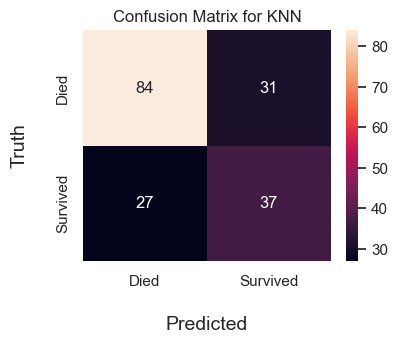

0


In [70]:
KNNy_pred = KNNclf.predict(X_valid)
print(f'Accuracy: {accuracy_score(y_valid, KNNy_pred)*100}')
conf_matrix(y_valid, KNNy_pred)

save_test_outputs(df_test, new_df_test, KNNclf, 'KNN')

Accuracy: 68.71508379888269


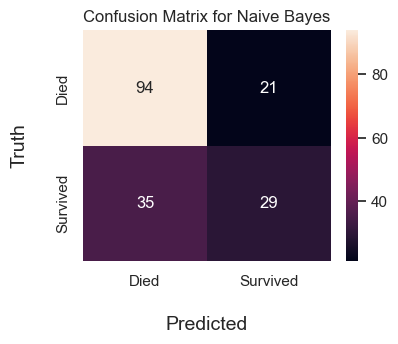

0


In [71]:
NBy_pred = NBclf.predict(X_valid)
print(f'Accuracy: {accuracy_score(y_valid, NBy_pred)*100}')
conf_matrix(y_valid, NBy_pred, 'Naive Bayes')
save_test_outputs(df_test, new_df_test, NBclf, 'NB')

Accuracy: 74.86033519553072


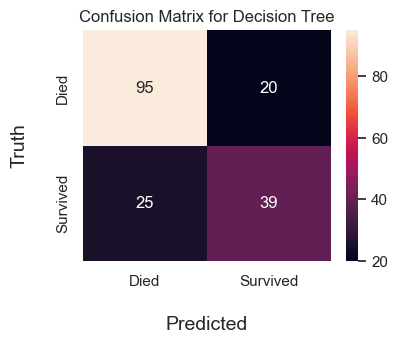

0


In [72]:
DTy_pred = DTclf.predict(X_valid)
print(f'Accuracy: {accuracy_score(y_valid, DTy_pred)*100}')
conf_matrix(y_valid, DTy_pred, 'Decision Tree')
save_test_outputs(df_test, new_df_test, DTclf, 'DT')

6/6 [==============================] - 0s 10ms/step
Accuracy: 75.41899441340783


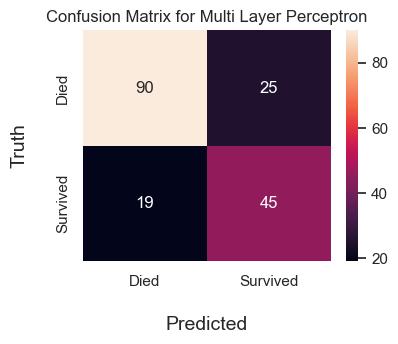

14/14 [==============================] - 0s 3ms/step
0


In [73]:
MLPy_pred = np.apply_along_axis(res, -1, MLPclf.predict(X_valid))
print(f'Accuracy: {accuracy_score(y_valid, MLPy_pred)*100}')
conf_matrix(y_valid, MLPy_pred, 'Multi Layer Perceptron')
save_test_outputs(df_test, new_df_test, MLPclf, 'MLP')

### Getting input data for the meta learner

In [81]:
p1 = KNNclf.predict(X_train)
p2 = NBclf.predict(X_train)
p3 = DTclf.predict(X_train)
# p4 = MLPclf.predict(X_train)
p4 = np.apply_along_axis(res, -1, MLPclf.predict(X_train))
meta_X_train = [p1,p2,p3,p4]
# meta_X_train = [p3,p4]
meta_X_train = np.transpose(meta_X_train)
meta_X_valid = np.transpose([KNNy_pred, NBy_pred, DTy_pred, MLPy_pred])
meta_X_train

p1_test = KNNclf.predict(new_df_test)
p2_test = NBclf.predict(new_df_test)
p3_test = DTclf.predict(new_df_test)
# p4 = MLPclf.predict(X_train)
p4_test = np.apply_along_axis(res, -1, MLPclf.predict(new_df_test))
meta_X_test = [p1_test ,p2_test ,p3_test ,p4_test]
meta_X_test = np.transpose(meta_X_test)


14/14 [==============================] - 0s 1ms/step


In [82]:
meta_X_test

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int64)

### Let's try __Voting__ before Stacking

In [74]:
voting_y_pred = np.apply_along_axis(np.bincount, 1, meta_X_valid, minlength=2)
voting_y_pred = np.apply_along_axis(np.argmax, 1, voting_y_pred)

Accuracy: 56.424581005586596


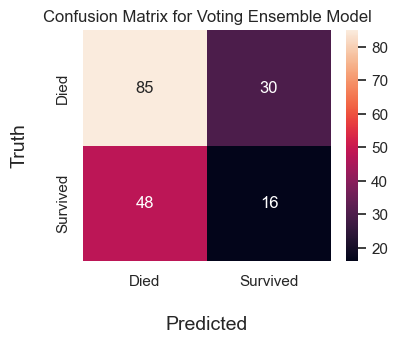

In [75]:
print(f'Accuracy: {accuracy_score(y_valid, voting_y_pred)*100}')
conf_matrix(y_valid, voting_y_pred, 'Voting Ensemble Model')

In [ ]:
# Weighted voting
# We add on each prediction of each base learner
# Giving more importance to a predictor compared to others
# (Doesn't work out well)

# weights = np.array([[1, 1, 3, 2]]*meta_X_valid.shape[0], dtype='int64')
# voting_y_pred = np.apply_along_axis(np.bincount, 1, meta_X_valid, weights=weights, minlength=2)
# voting_y_pred = np.apply_along_axis(np.argmax, 1, voting_y_pred)

# print(f'Accuracy: {accuracy_score(y_valid, voting_y_pred)*100}')
# conf_matrix(y_valid, voting_y_pred)

### Let's continue with the stacking model (manual)

In [76]:
# Define the meta learner
LRclf = LogisticRegression()
LRclf.fit(meta_X_train, y_train)

LogisticRegression()

In [99]:
np.unique(meta_X_train, return_counts=True)

(array([0, 1], dtype=int64), array([1873,  975], dtype=int64))

* Due to the high sparsity of the training dataset (mega_X_train) the Logistic Regression is not reliable
* Let's try with just for application purpose, but we could already predict that the result will be bad

In [95]:
y_train.value_counts()

Survived
0    434
1    278
Name: count, dtype: int64

In [89]:
LRclf.predict([meta_X_train[3]])

array([0], dtype=int64)

In [77]:
meta_X_valid = np.transpose([KNNy_pred, NBy_pred, DTy_pred, MLPy_pred])
# meta_X_valid = np.transpose([DTy_pred, MLPy_pred])
final_y_pred = LRclf.predict(meta_X_valid)
final_y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

* Like we said, LR doesn't work,its prediction only got one classe (0)

Accuracy: 64.24581005586593


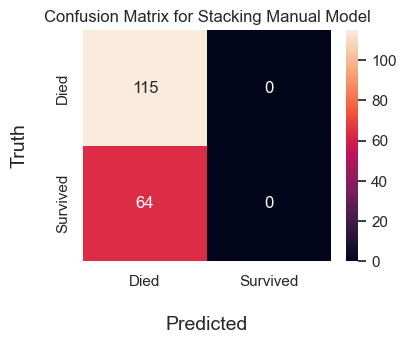

0


In [83]:
print(f'Accuracy: {accuracy_score(y_valid, final_y_pred)*100}')
conf_matrix(y_valid, final_y_pred, 'Stacking Manual Model')
save_test_outputs(df_test, meta_X_test, LRclf, 'manual_Stack')

### 4. Initialize and fit Meta Learner (Automatic stacking)

In [33]:
base_learners = [('knn', KNNclf), ('nb', NBclf), ('dt',DTclf)]
# base_learners = [('knn', KNeighborsClassifier()), ('nb', MultinomialNB()), ('dt',DecisionTreeClassifier())]
#base_learners = [DTclf]
meta_learner = LogisticRegression()

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=10)

In [34]:
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('knn', KNeighborsClassifier()),
                               ('nb', MultinomialNB()),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

In [35]:
y_pred = stacking_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy*100} %")
save_test_outputs(df_test, new_df_test, stacking_model, 'Stack')

Accuracy: 79.3296089385475 %


Accuracy: 77.6536312849162 %


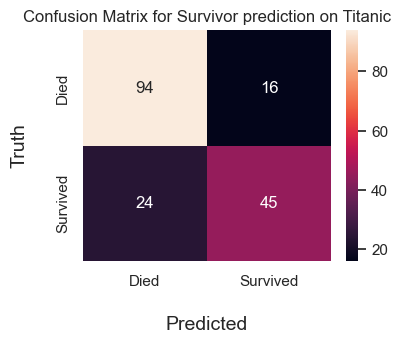

In [ ]:
print(f'Accuracy: {accuracy_score(y_valid, y_pred)*100} %')
conf_matrix(y_valid, y_pred, 'Stacking Automatic Model')